In [18]:
### 1️⃣ Importowanie bibliotek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import unittest

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jkola\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\jkola\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
### 2️⃣ Wczytanie danych
def load_data(train_path, test_path):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)
    if 'Unnamed: 133' in train_df.columns:
        train_df.drop(columns=['Unnamed: 133'], inplace=True)
    
    # Usunięcie kolumny "Fluid Overload" z obu zbiorów
    if 'fluid_overload' in train_df.columns:
        train_df.drop(columns=['fluid_overload'], inplace=True)
    if 'fluid_overload' in test_df.columns:
        test_df.drop(columns=['fluid_overload'], inplace=True)

    return train_df, test_df

In [20]:
### 3️⃣ Normalizacja tekstu
def normalize_text(text):
    text = text.lower().strip()  # Zamiana na małe litery i usunięcie zbędnych spacji
    text = re.sub(r'[^a-z\s]', '', text)  # Usunięcie znaków specjalnych i cyfr
    
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]  # Usunięcie stop words
    
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]  # Lematyzacja
    
    words = list(dict.fromkeys(words))  # Usunięcie duplikatów
    return ' '.join(words).title()  # Formatowanie tekstu (pierwsza litera każdego słowa wielka)


In [29]:
### 4️⃣ Przetwarzanie danych
def preprocess_data(train_df, test_df):
    # Normalizacja tekstu w 'prognosis'
    train_df['prognosis'] = train_df['prognosis'].apply(normalize_text)
    test_df['prognosis'] = test_df['prognosis'].apply(normalize_text)
    
    # Podział na cechy (X) i etykiety (y)
    X = train_df.drop(columns=['prognosis'])
    y = train_df['prognosis']
    
    # Kodowanie etykiet
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Skalowanie cech
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Podział na zbiór treningowy i walidacyjny
    X_train, X_val, y_train, y_val = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)
    
    return X_train, X_val, y_train, y_val, label_encoder, scaler, train_df


In [22]:
### 5️⃣ Macierz korelacji
def plot_correlation_matrix(train_df):
    # Tymczasowe kodowanie celu
    target = 'prognosis'
    le_temp = LabelEncoder()
    train_df_encoded = train_df.copy()
    train_df_encoded[target] = le_temp.fit_transform(train_df_encoded[target])

    # Tworzenie macierzy korelacji
    plt.figure(figsize=(25, 25))
    correlation_matrix = train_df_encoded.corr()
    sns.heatmap(
        correlation_matrix,
        annot=False,  # Nie wyświetlaj liczb wewnątrz komórek
        fmt=".2f",
        cmap="coolwarm",
        cbar=True,
        xticklabels=correlation_matrix.columns,
        yticklabels=correlation_matrix.columns
    )
    plt.title("Macierz korelacji", fontsize=18)
    plt.xticks(fontsize=10, rotation=90)  # Obrót osi X
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

In [23]:
### 6️⃣ Gęstościowa mapa cieplna (symptomy vs choroby)
def plot_symptom_disease_heatmap(train_df):
    target = 'prognosis'
    symptoms = train_df.drop(columns=[target]).columns

    # Obliczanie średniego występowania symptomów dla każdej choroby i normalizacja
    symptom_rates = train_df.groupby(target)[symptoms].mean()
    normalized_rates = symptom_rates / train_df[symptoms].mean()

    # Rysowanie mapy cieplnej
    plt.figure(figsize=(15, 20))
    sns.heatmap(
        normalized_rates.T,
        cmap="viridis",
        annot=False,
        cbar=True,
        xticklabels=train_df[target].unique(),
        yticklabels=symptoms,
        linewidths=0.5,
        linecolor="white"
    )
    plt.title("Mapa cieplna symptomów vs choroby", fontsize=16)
    plt.xlabel("Choroby", fontsize=12)
    plt.ylabel("Symptomy", fontsize=12)
    plt.xticks(rotation=45, fontsize=10, ha="right")
    plt.yticks(fontsize=10, rotation=0, va="center")
    plt.tight_layout()
    plt.show()


In [24]:
### 7️⃣ Trenowanie modelu
def train_model(X_train, y_train, model_type='RandomForest'):
    # Wybór modelu
    if model_type == 'RandomForest':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif model_type == 'SVM':
        model = SVC(kernel='rbf', probability=True)
    elif model_type == 'GradientBoosting':
        model = GradientBoostingClassifier(n_estimators=100, random_state=42)
    
    # Definicja siatki hiperparametrów
    param_grid = {'n_estimators': [50, 100, 200]} if model_type != 'SVM' else {'C': [0.1, 1, 10]}
    
    # Przeszukiwanie najlepszych hiperparametrów
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_


In [25]:
### 8️⃣ Ocena modelu
def evaluate_model(model, X_val, y_val, label_encoder):
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    
    print(f"Dokładność modelu: {accuracy:.4f}")
    print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))
    
    # Wizualizacja macierzy konfuzji
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title("Macierz konfuzji")
    plt.xlabel("Przewidziane")
    plt.ylabel("Rzeczywiste")
    plt.show()


In [26]:
### 9️⃣ Testowanie na zbiorze testowym
def test_on_data(model, test_df, label_encoder, scaler):
    # Przygotowanie danych testowych
    test_X = test_df.drop(columns=['prognosis'])
    test_y = test_df['prognosis']
    
    # Kodowanie etykiet
    test_y_encoded = label_encoder.transform(test_y)
    
    # Skalowanie cech
    test_X_scaled = scaler.transform(test_X)
    
    # Przewidywanie i ocena modelu
    test_pred = model.predict(test_X_scaled)
    test_accuracy = accuracy_score(test_y_encoded, test_pred)
    
    print(f"Dokładność na zbiorze testowym: {test_accuracy:.4f}")
    return test_accuracy


In [30]:
### 🔟 Testy jednostkowe
class TestDiseaseModel(unittest.TestCase):
    def setUp(self):
        # Wczytanie danych treningowych i testowych
        self.train_df, self.test_df = load_data("data/train_disease.csv", "data/test_disease.csv")
        
        # Przetworzenie danych i podział na zbiory treningowe i walidacyjne
        self.X_train, self.X_val, self.y_train, self.y_val, self.label_encoder, self.scaler, _ = preprocess_data(self.train_df, self.test_df)
        
        # Trenowanie modelu
        self.model = train_model(self.X_train, self.y_train)
    
    def test_model_training(self):
        # Sprawdzenie, czy model nie jest pusty po treningu
        self.assertIsNotNone(self.model, "Model nie powinien być None po treningu")
    
    def test_prediction_shape(self):
        # Sprawdzenie, czy liczba predykcji zgadza się z liczbą próbek walidacyjnych
        y_pred = self.model.predict(self.X_val)
        self.assertEqual(len(y_pred), len(self.y_val), "Liczba predykcji powinna odpowiadać liczbie próbek w zbiorze walidacyjnym")
    
    def test_accuracy_threshold(self):
        # Sprawdzenie, czy dokładność modelu na zbiorze testowym jest powyżej 70%
        test_acc = test_on_data(self.model, self.test_df, self.label_encoder, self.scaler)
        self.assertGreater(test_acc, 0.7, "Dokładność na zbiorze testowym powinna być większa niż 70%")

if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)


.

Dokładność na zbiorze testowym: 0.9762


..
----------------------------------------------------------------------
Ran 3 tests in 16.154s

OK


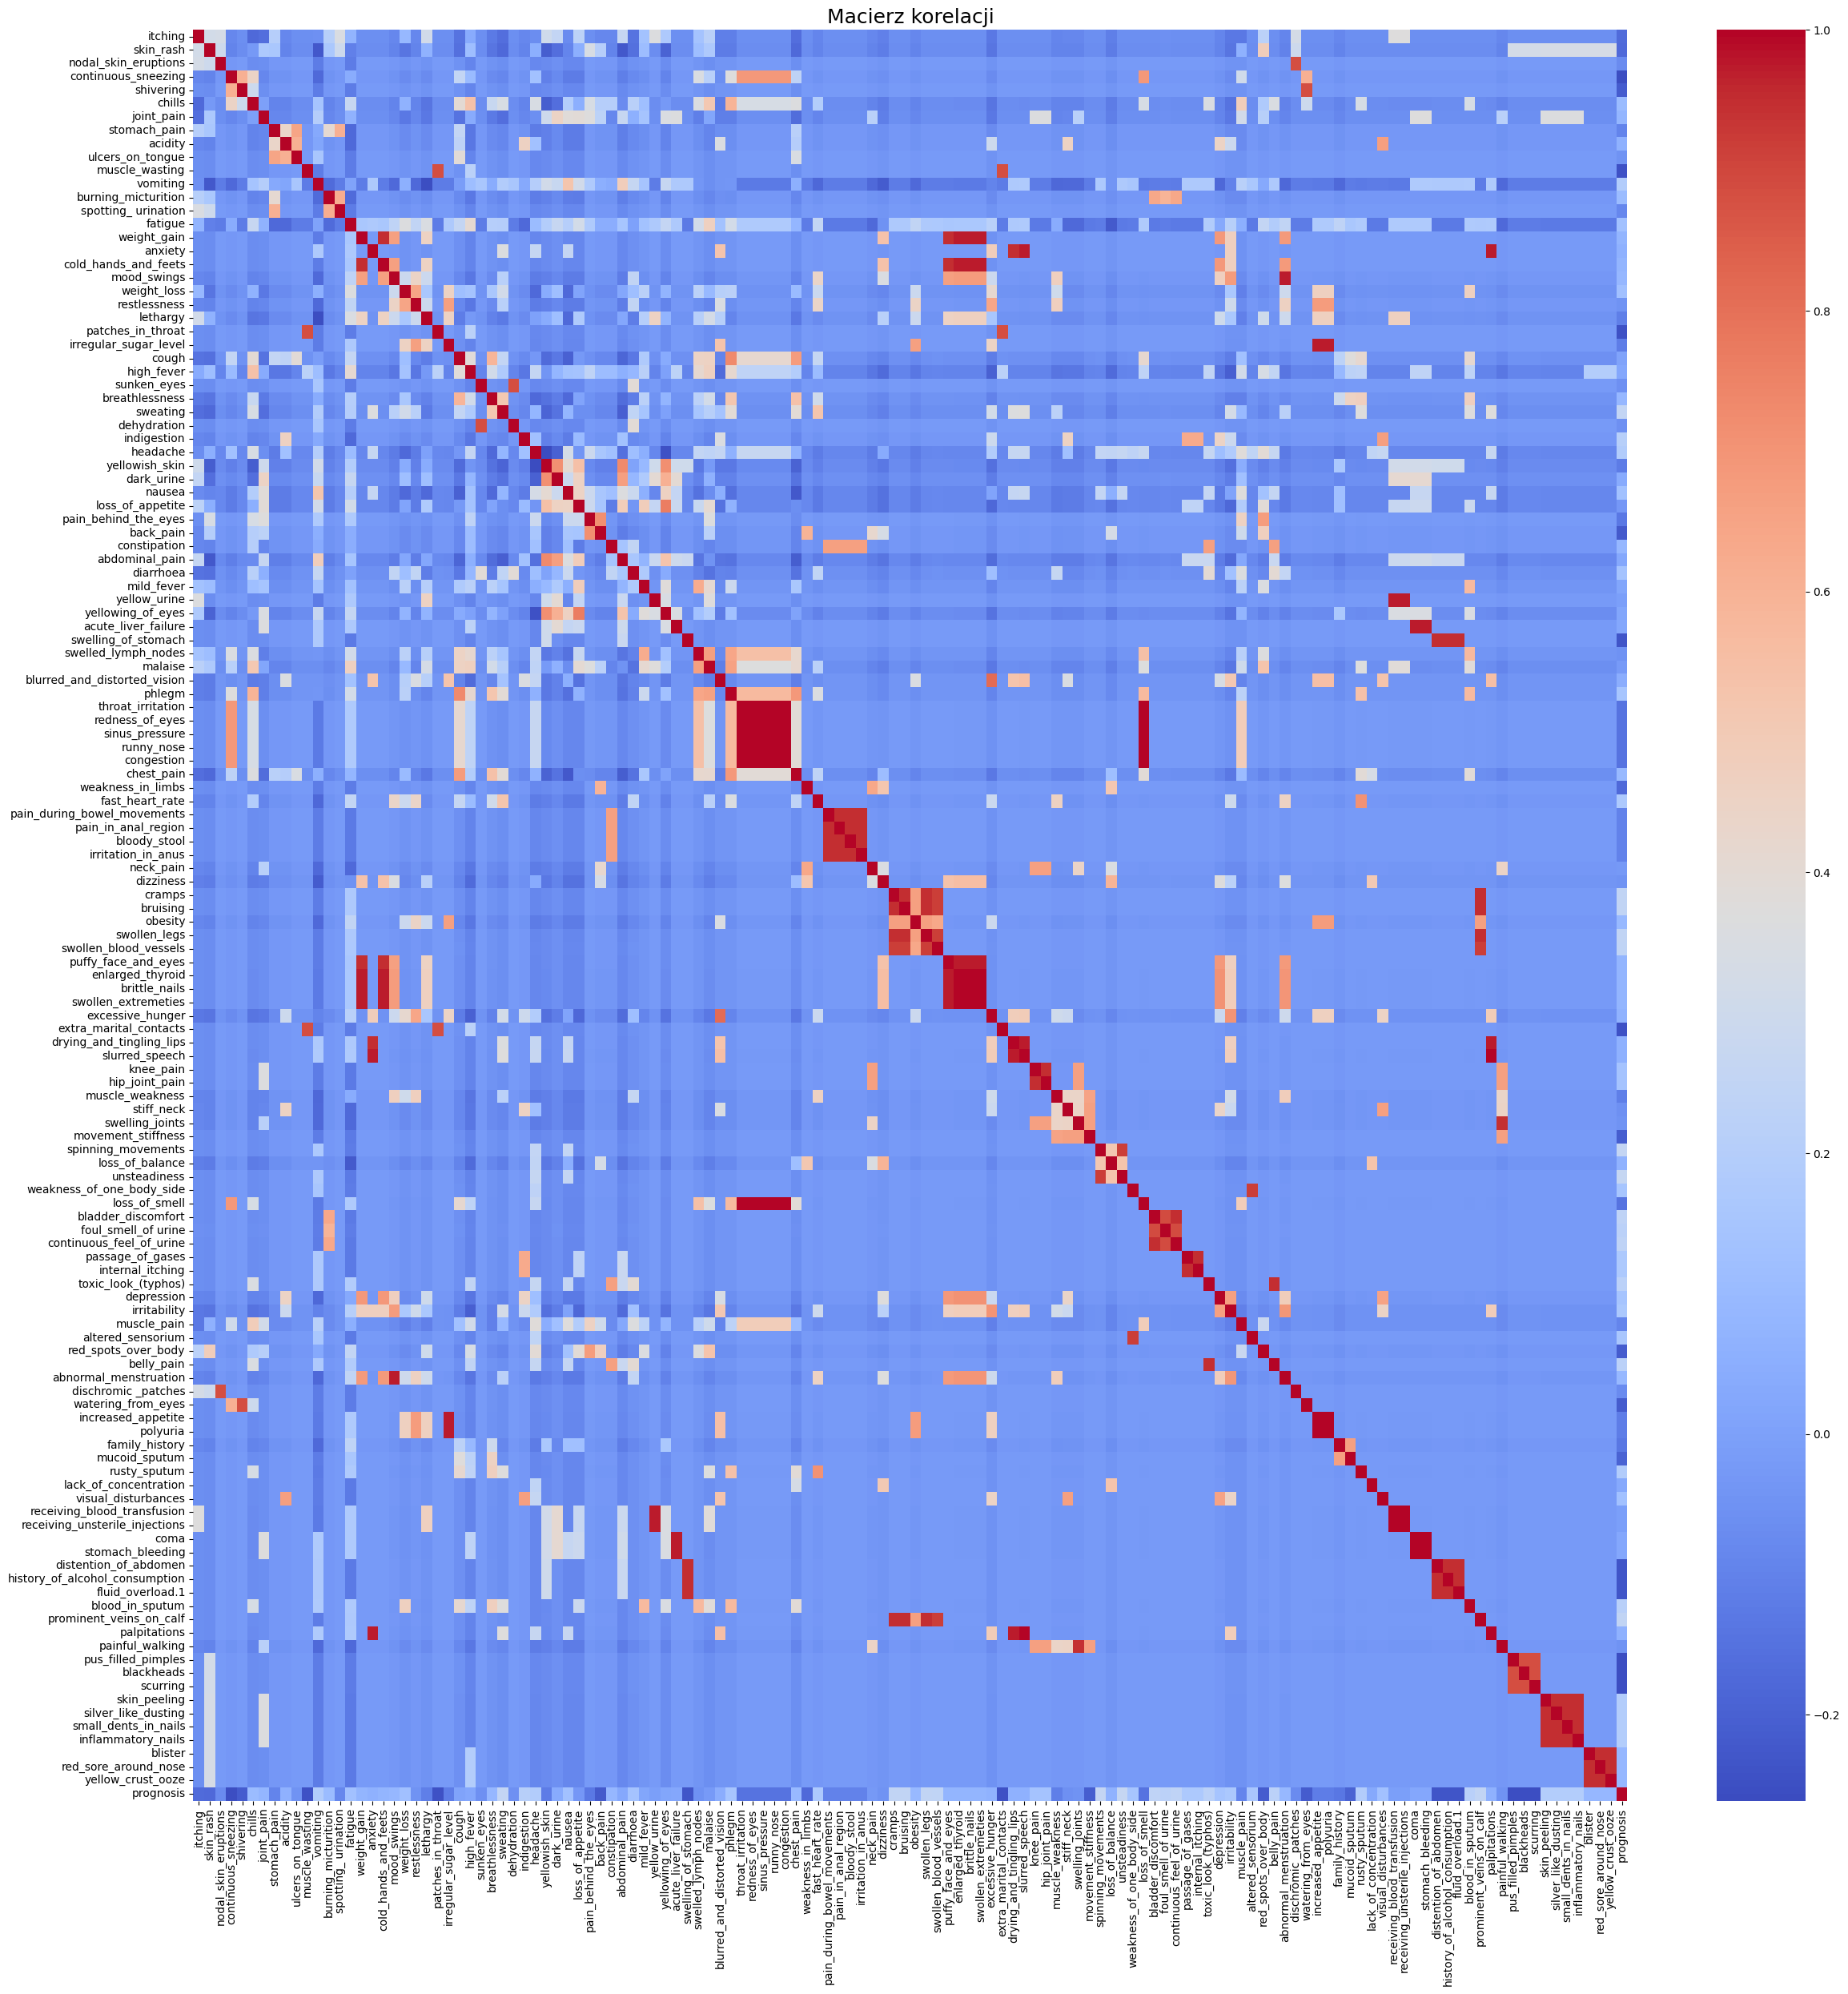

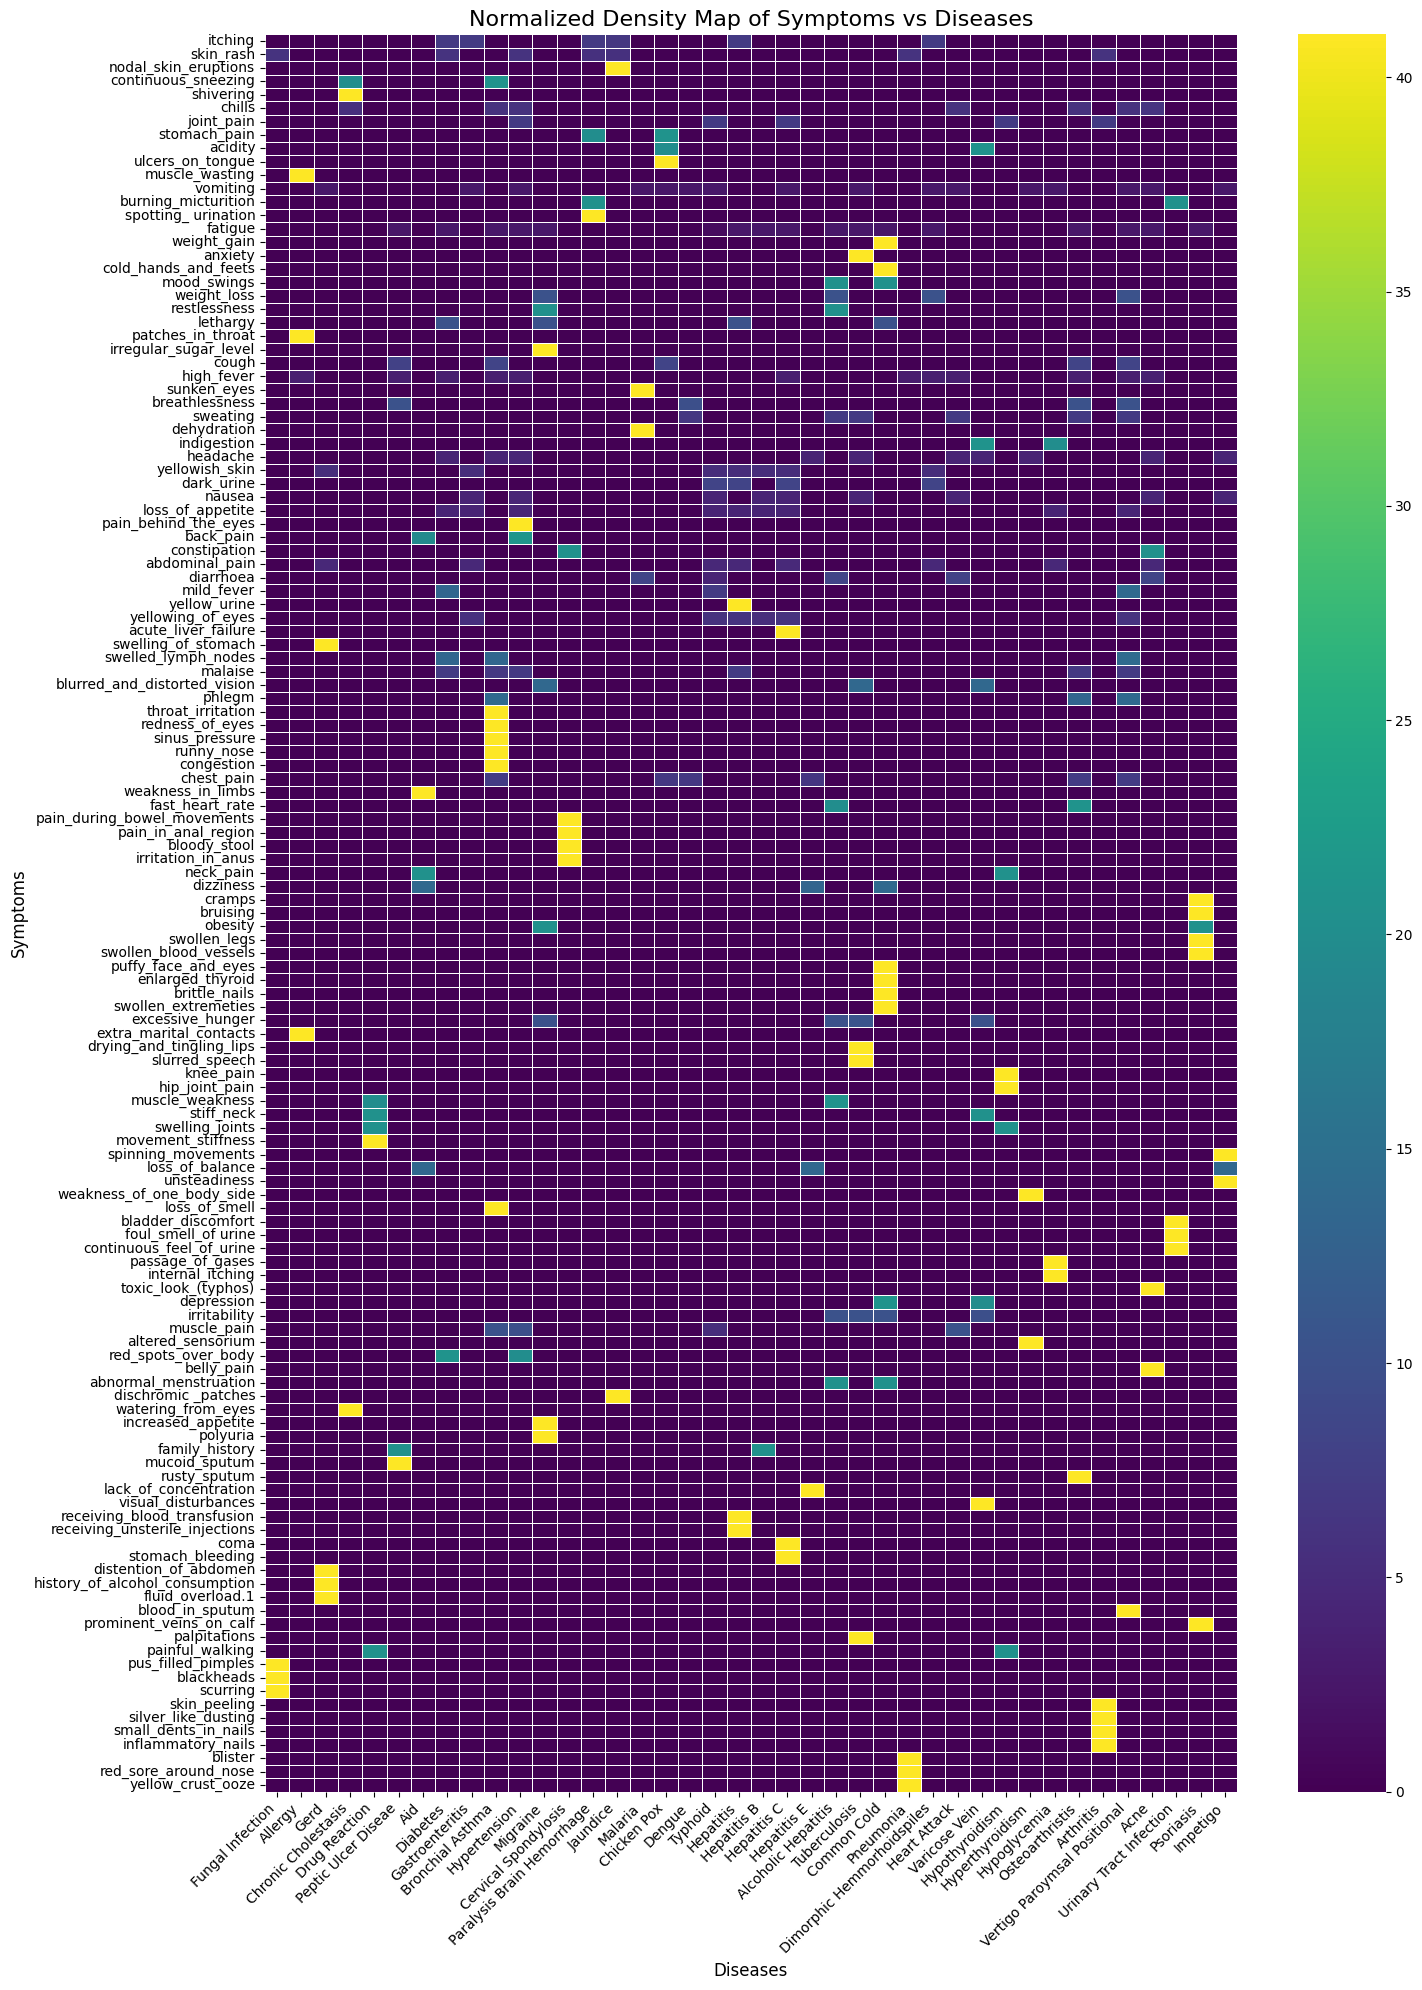

Dokładność modelu: 1.0000
                              precision    recall  f1-score   support

                        Acne       1.00      1.00      1.00        24
                         Aid       1.00      1.00      1.00        30
         Alcoholic Hepatitis       1.00      1.00      1.00        25
                     Allergy       1.00      1.00      1.00        24
                   Arthritis       1.00      1.00      1.00        23
            Bronchial Asthma       1.00      1.00      1.00        33
        Cervical Spondylosis       1.00      1.00      1.00        23
                 Chicken Pox       1.00      1.00      1.00        21
         Chronic Cholestasis       1.00      1.00      1.00        15
                 Common Cold       1.00      1.00      1.00        23
                      Dengue       1.00      1.00      1.00        26
                    Diabetes       1.00      1.00      1.00        21
  Dimorphic Hemmorhoidspiles       1.00      1.00      1.00    

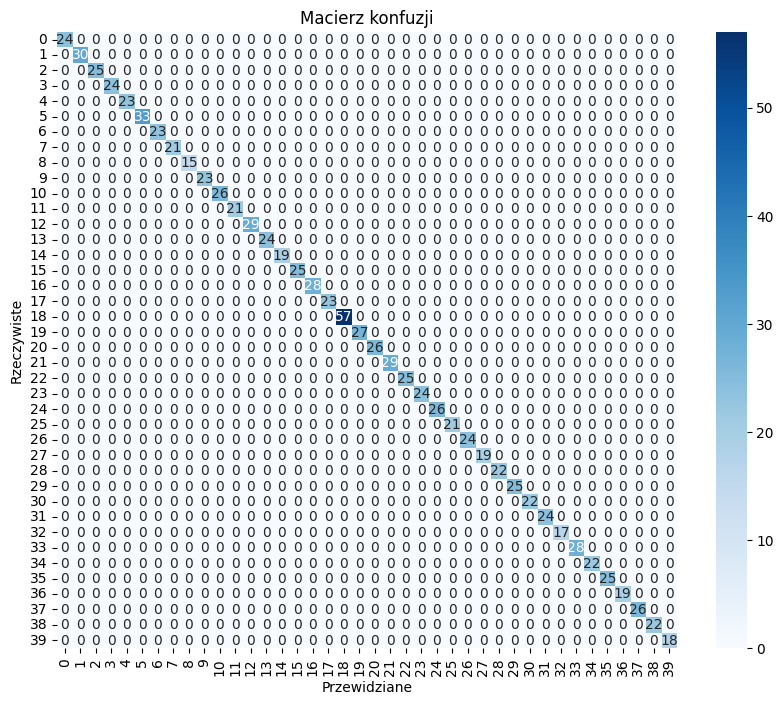

Dokładność na zbiorze testowym: 0.9762


0.9761904761904762

In [31]:
### 🔟 Wykonanie kodu

# Wczytanie danych treningowych i testowych
train_df, test_df = load_data("data/train_disease.csv", "data/test_disease.csv")

# Przetwarzanie danych i usuwanie zbędnej kolumny przed wizualizacjami
train_df, test_df = preprocess_data(train_df, test_df)[6], test_df  

# Tworzenie wykresów wizualizujących dane
plot_correlation_matrix(train_df)
plot_symptom_disease_heatmap(train_df)

# Przetwarzanie danych i podział na zbiory treningowe, walidacyjne i skalowanie
X_train, X_val, y_train, y_val, label_encoder, scaler, train_df = preprocess_data(train_df, test_df)

# Trenowanie modelu
model = train_model(X_train, y_train)

# Ocena modelu na zbiorze walidacyjnym
evaluate_model(model, X_val, y_val, label_encoder)

# Testowanie modelu na zbiorze testowym
test_on_data(model, test_df, label_encoder, scaler)
